In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

/Users/yangli/miniconda2/envs/PUBG/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yangli/miniconda2/envs/PUBG/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [18]:
train = pd.read_csv('../data/train_V2.csv')
test = pd.read_csv('../data/test_V2.csv')
sub = pd.read_csv('../data/sample_submission_V2.csv')

print("done")

done


In [19]:
# get_dummy for categoricial data
# categorical_feature = ['matchType']
# train = pd.get_dummies(train, columns = categorical_feature)
# test = pd.get_dummies(test, columns = categorical_feature)

train = train.drop(columns = ['matchType'])

print(train[:10])

               Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
5  ff79c12f326506  289a6836a88d27  bac52627a12114        0       0   
6  95959be0e21ca3  2c485a1ad3d0f1  a8274e903927a2        0       0   
7  311b84c6ff4390  eaba5fcb7fc1ae  292611730ca862        0       0   
8  1a68204ccf9891  47cfbb04e1b1a2  df014fbee741c6        0       0   
9  e5bb5a43587253  759bb6f7514fd2  3d3031c795305b        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace      ...       revives  \
0        0.000      0              0      0         60      ...             0   
1       91.470      0              0      0         57      ...    

In [23]:
# normalize data
train_x = train.drop(columns = ['Id','groupId','matchId','winPlacePerc'])
train_all = train.drop(columns = ['Id','groupId','matchId'])
test_x = test.drop(columns = ['Id','groupId','matchId'])


print(train_all.corr())

                  assists    boosts  damageDealt     DBNOs  headshotKills  \
assists          1.000000  0.307683     0.406726  0.301057       0.198289   
boosts           0.307683  1.000000     0.521947  0.358907       0.334661   
damageDealt      0.406726  0.521947     1.000000  0.735763       0.613409   
DBNOs            0.301057  0.358907     0.735763  1.000000       0.469923   
headshotKills    0.198289  0.334661     0.613409  0.469923       1.000000   
heals            0.228556  0.535854     0.342987  0.265485       0.199918   
killPlace       -0.290062 -0.554844    -0.677398 -0.555289      -0.469829   
killPoints       0.039066  0.008347     0.049904  0.042616       0.023988   
kills            0.319690  0.502024     0.888783  0.707848       0.674275   
killStreaks      0.243471  0.405327     0.703599  0.646872       0.512882   
longestKill      0.261425  0.423290     0.563837  0.451422       0.447261   
matchDuration   -0.019450  0.072108    -0.006755 -0.014485      -0.017657   

In [44]:
import matplotlib.ticker as ticker

labels = list(train_all)

fig = plt.figure(figsize=(15,15))
subplot = fig.add_subplot(111)

subplot.matshow(train_all.corr())

subplot.set_xticklabels(['']+labels)
subplot.set_yticklabels(['']+labels)

subplot.xaxis.set_major_locator(ticker.MultipleLocator(1))
subplot.yaxis.set_major_locator(ticker.MultipleLocator(1))

subplot.xaxis.set_tick_params(rotation=90)
# subplot.yaxis.set_tick_params(rotation=45)


plt.savefig('../output/corr.png')

In [99]:
from sklearn.mixture import GaussianMixture

# train_all = train_all.drop(columns = ['winPlacePerc'])

# gm = GaussianMixture(n_components=K, n_init=3, init_params='random', tol=1e-3, max_iter=1000)

train_useful = train_x[['walkDistance', 'rideDistance',
                       'revives', 'longestKill', 'killStreaks',
                       'kills', 'heals', 'damageDealt', 'boosts']]

gm = GaussianMixture(n_components=4)
gm.fit(train_useful)

print("done")

# train_all['winPlacePerc'].isnull()
# nan_rows = df[df.isnull().any(1)]

done


In [101]:
# gm_params = gm.get_params()
# gm_params_true = gm.get_params(deep=True)

test_x = test.drop(columns = ['Id','groupId','matchId', 'matchType'])

test_useful = test_x[['walkDistance', 'rideDistance',
                       'revives', 'longestKill', 'killStreaks',
                       'kills', 'heals', 'damageDealt', 'boosts']]

gm_predictions = gm.predict(test_useful)


print(gm_predictions[:10])

# predictions = gm.predict(x_test)

[0 1 3 0 2 0 2 0 3 0]


In [115]:
PLOT_COLORS = ['red', 'green', 'blue', 'orange', 'purple']

def plot_gmm_preds(x, z, col_1, col_2, file_name):
    """Plot GMM predictions on a 2D dataset `x` with labels `z`.

    Write to the output directory, including `plot_id`
    in the name, and appending 'ss' if the GMM had supervision.

    NOTE: You do not need to edit this function.
    """
    plt.figure(figsize=(12, 8))
    plt.title('{} GMM Predictions'.format('Unsupervised'))
    plt.xlabel('x_1')
    plt.ylabel('x_2')
#     plt.set_xlim([0,600])
#     axes.set_ylim([ymin,ymax])

    for x_1, x_2, z_ in zip(x[col_1], x[col_2], z):
        if x_1 <=600 and x_2 <= 500:
            color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
            alpha = 0.25 if z_ < 0 else 0.75
            plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)

    save_path = '../output/' + file_name
    plt.savefig(save_path)

    
def plot_gmm_preds_3d(x, z, col_1, col_2, col_3, file_name):
    """Plot GMM predictions on a 2D dataset `x` with labels `z`.

    Write to the output directory, including `plot_id`
    in the name, and appending 'ss' if the GMM had supervision.

    NOTE: You do not need to edit this function.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('{} GMM Predictions'.format('Unsupervised'))
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, x_3, z_ in zip(x[col_1], x[col_2], x[col_3], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        ax.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)

    save_path = '../output/' + file_name
    plt.savefig(save_path)

In [117]:
test_plt = test_useful[0:1000]


# print(test_plt[0:10])

plot_gmm_preds(test_plt, gm_predictions, 'damageDealt', 'walkDistance', 'gm.png')

print('done')


done


In [100]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4)
km.fit(train_useful)

print("done")

done


[0 1 0 3 3 0 0 0 2 3]


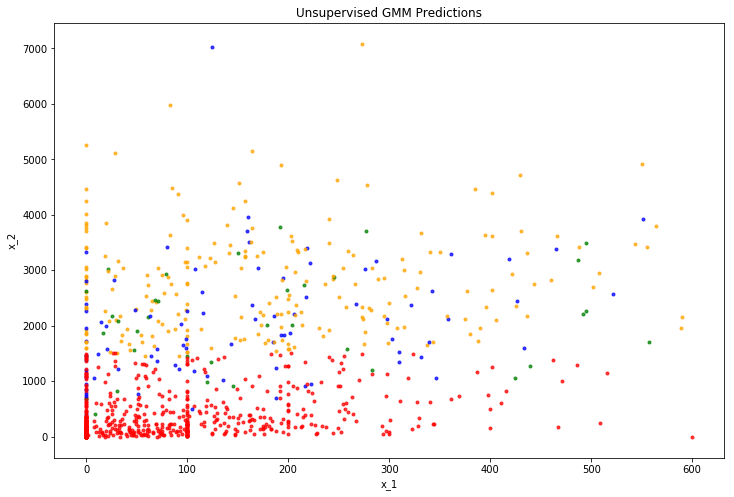

In [114]:
km_predictions = km.predict(test_useful)

print(km_predictions[:10])

plot_gmm_preds(test_plt, km_predictions, 'damageDealt', 'walkDistance', 'em.png')